<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparing" data-toc-modified-id="Data-Preparing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparing</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inference</a></span></li></ul></div>

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GroupKFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, LayerNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv1DTranspose
, Conv2D, Conv2DTranspose
, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
# MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import losses
# MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy, CosineSimilarity
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import linear, sigmoid, relu
from tensorflow.keras.initializers import RandomNormal, glorot_uniform, he_uniform, Constant
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")
plt.style.use("dark_background")

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices("GPU")
# if gpu_devices:
#     print("Using GPU")
#     tf.config.experimental.set_memory_growth(gpu_devices[0], True)
# else:
#     print("Using CPU")

# sb.set_style("whitegrid")
# np.random.seed(42)

In [3]:
# hists_path = Path("hists", "multivariate_time_series")
# if not hists_path.exists():
#     hists_path.mkdir(parents=True)

# Data Preparing

In [4]:
data = web.DataReader(name=["UMCSENT", "IPGMFN"], data_source="fred", start="1980", end="2021-12")
data.columns = ["cs", "ip"]
data = data.dropna()

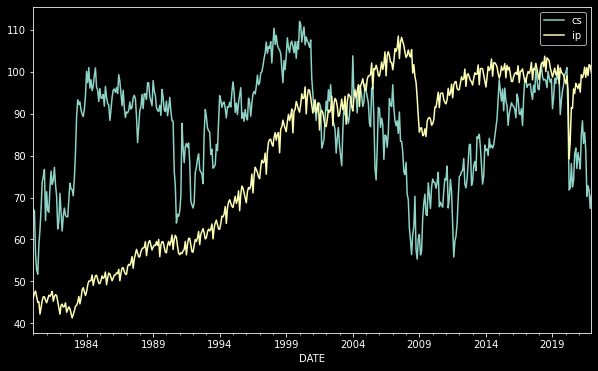

In [5]:
data.plot.line(figsize=(10, 6));

In [6]:
# Data Transformation
data_tf = pd.DataFrame()
data_tf["cs"] = data["cs"].diff(12).dropna()
data_tf["ip"] = data["ip"].diff(12).dropna()
data_tf["ip"] = np.log(data["ip"]).diff(12)

# Feature Scaling
sc = StandardScaler()
# sc = MinMaxScaler()
data_tf = pd.DataFrame(sc.fit_transform(data_tf), index=data_tf.index, columns=data_tf.columns)

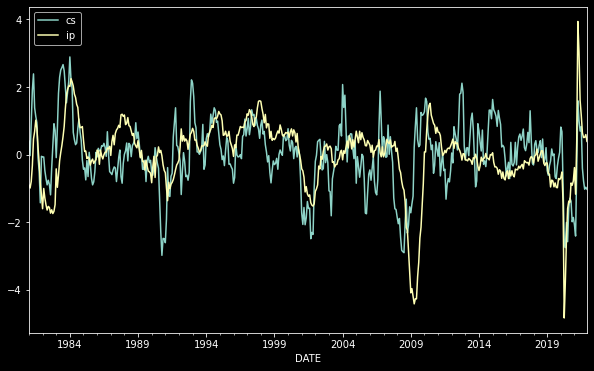

In [7]:
data_tf.plot.line(figsize=(10, 6));

In [8]:
def blocked_cv(data, window_size, h, step=1):
    X = list()
    y = list()
    for i in range(0, len(data) - window_size - h + 1, step):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + h])
    return np.array(X), np.array(y)

window_size = 20
h = 1
X, y = blocked_cv(data_tf, window_size, h)
y = y[:, 0, :]

print(X.shape)
print(y.shape)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=24, shuffle=False)

(472, 20, 2)
(472, 2)


# Modeling

In [9]:
n_features = 2

inputs = Input(shape=(window_size, n_features))

z = LSTM(units=200, dropout=0.1, recurrent_dropout=0.1, return_sequences=False)(inputs)
z = Dense(units=128)(z)
outputs = Dense(units=n_features)(z)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 2)]           0         
                                                                 
 lstm (LSTM)                 (None, 200)               162400    
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 188,386
Trainable params: 188,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer="adam", loss="mse", metrics=["mse"])
es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=10)
model_path = "cs_ip_LSTM.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_loss", mode="auto", verbose=1, save_best_only=True)
hist = model.fit(x=X_tr, y=y_tr, validation_split=0.2, epochs=100, batch_size=32, verbose=2, shuffle=False, callbacks=[es, mc])

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.33034, saving model to cs_ip_LSTM.h5
12/12 - 3s - loss: 0.5541 - mse: 0.5541 - val_loss: 0.3303 - val_mse: 0.3303 - 3s/epoch - 228ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.33034 to 0.23192, saving model to cs_ip_LSTM.h5
12/12 - 1s - loss: 0.3379 - mse: 0.3379 - val_loss: 0.2319 - val_mse: 0.2319 - 848ms/epoch - 71ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.23192 to 0.18769, saving model to cs_ip_LSTM.h5
12/12 - 1s - loss: 0.2547 - mse: 0.2547 - val_loss: 0.1877 - val_mse: 0.1877 - 835ms/epoch - 70ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.18769
12/12 - 1s - loss: 0.2321 - mse: 0.2321 - val_loss: 0.2068 - val_mse: 0.2068 - 718ms/epoch - 60ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.18769
12/12 - 1s - loss: 0.2145 - mse: 0.2145 - val_loss: 0.1973 - val_mse: 0.1973 - 778ms/epoch - 65ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.18769
12/12 - 1s - loss: 0.2090 

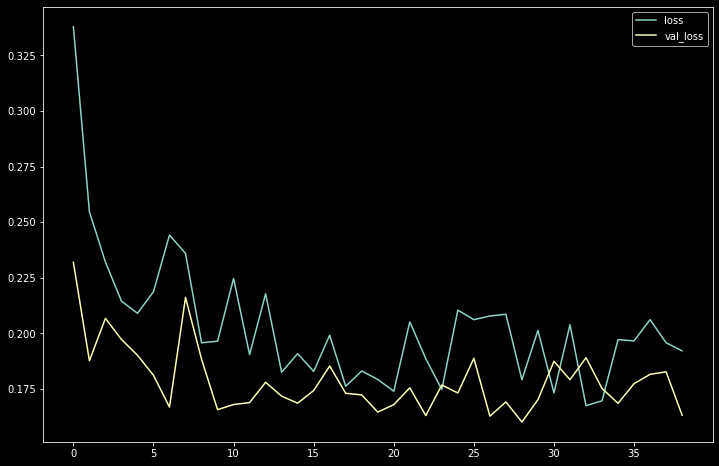

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.plot(hist.history["loss"][1:], label="loss");
axes.plot(hist.history["val_loss"][1:], label="val_loss");
axes.legend();

# Inference

In [22]:
temp = data_tf.tail(24)
y_pred = pd.DataFrame(model.predict(X_te), columns=temp.columns, index=temp.index)

1/1 [==============================] - 0s 16ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

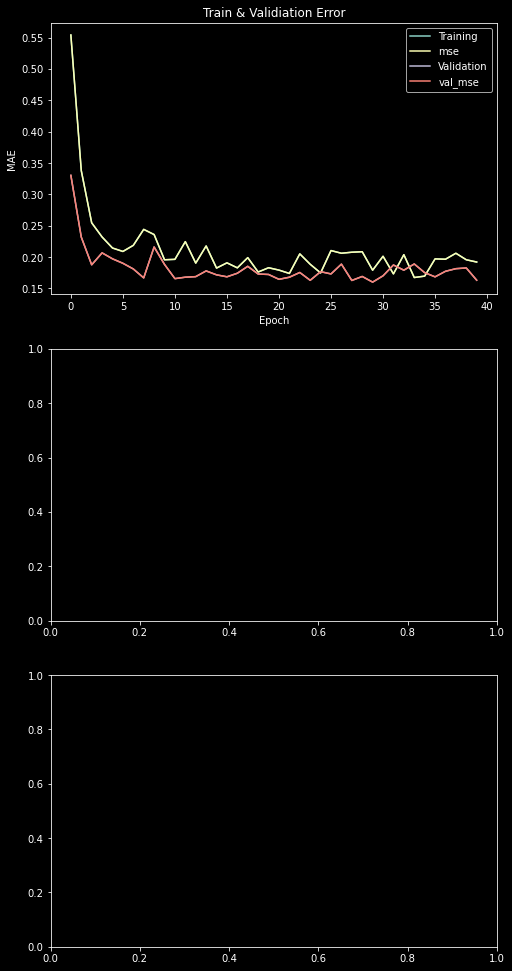

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(8, 17))
pd.DataFrame(hist.history).rename(columns={"loss": "Training",
                                              "val_loss": "Validation"}).plot(ax=axes[0], title="Train & Validiation Error")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MAE")
col_dict = {"ip": "Industrial Production", "cs": "cs"}

for i, col in enumerate(y_pred.columns, 1):
    y_tr.loc["2010":, col].plot(ax=axes[i], label="training", title=col_dict[col])
    y_te[col].plot(ax=axes[i], label="out-of-sample")
    y_pred[col].plot(ax=axes[i], label="prediction")
    axes[i].set_xlabel("")

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_te.index, y1=0.5, y2=0.9, color="grey", alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_te.index, y1=0.3, y2=0.9, color="grey", alpha=.5)

plt.legend()
fig.suptitle("Multivariate Forecast - hists | Test MAE = {:.4f}".format(test_mae), fontsize=14)
sb.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(hists_path / "multivariate_hists", dpi=300);